# 0. 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import re
from collections import Counter
from kiwipiepy import Kiwi
kiwi=Kiwi()
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# 1. 데이터 확인

In [2]:
train_data_path ="~/aiffel/dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3950 entries, 0 to 3949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           3950 non-null   int64 
 1   class         3950 non-null   object
 2   conversation  3950 non-null   object
dtypes: int64(1), object(2)
memory usage: 92.7+ KB
None


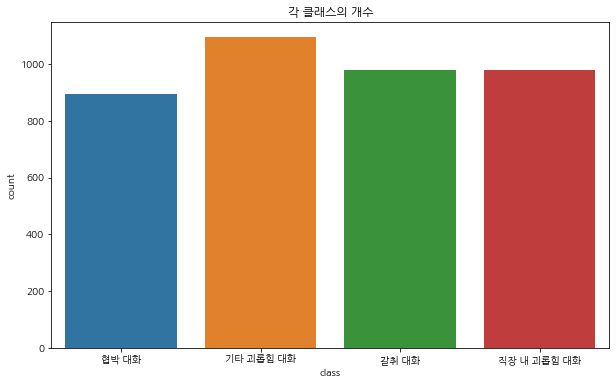

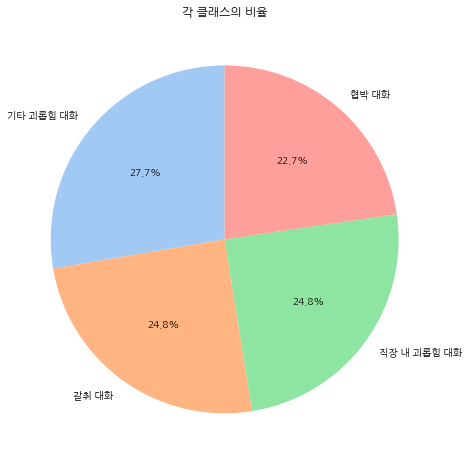

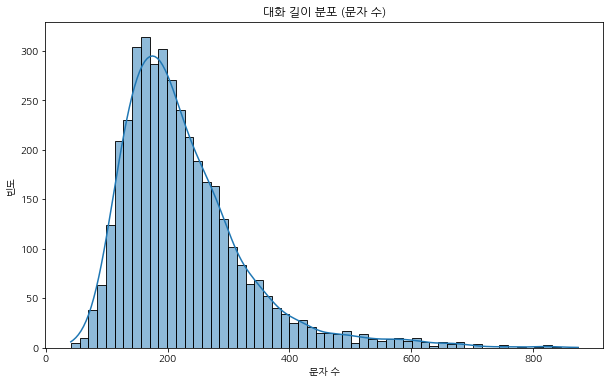

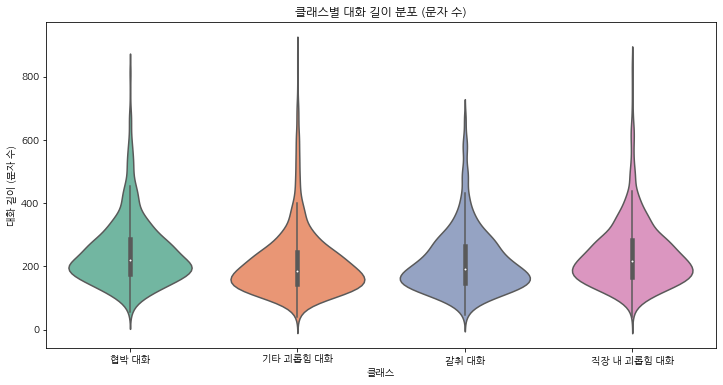

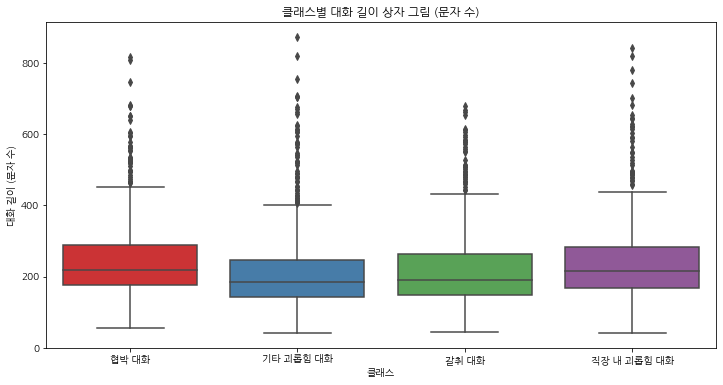

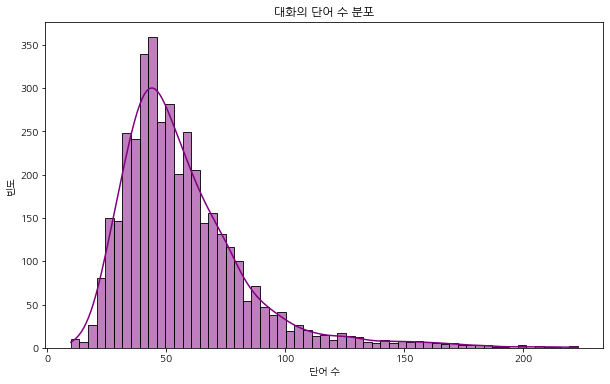

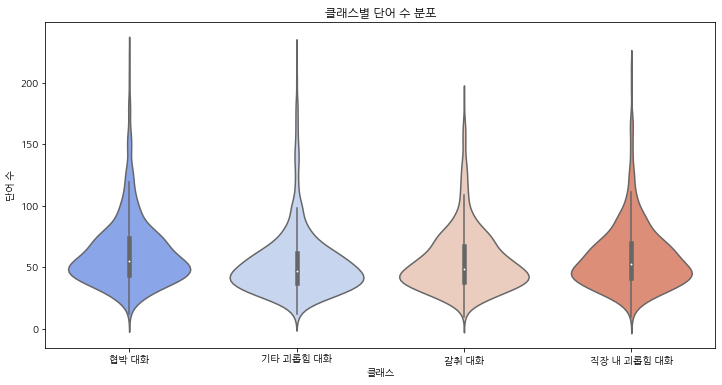

In [3]:
# 한글 폰트 설정 (여기서는 'NanumGothic' 폰트를 사용)
plt.rcParams['font.family'] = 'NanumGothic'

# 데이터 기본 정보 확인
print("Train Data Info:")
print(train_data.info())  # 데이터 타입, 결측치 확인

# 1. 'class' 컬럼의 분포 확인
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=train_data)
plt.title('각 클래스의 개수')
plt.show()

# 2. 'class' 컬럼의 비율을 Pie Chart로 시각화
plt.figure(figsize=(8, 8))
train_data['class'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('각 클래스의 비율')
plt.ylabel('')  # Y-label 제거
plt.show()

# 3. 'conversation' 텍스트의 길이 분포 확인 (각 문장의 문자 수)
train_data['text_length'] = train_data['conversation'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(train_data['text_length'], kde=True)
plt.title('대화 길이 분포 (문자 수)')
plt.xlabel('문자 수')
plt.ylabel('빈도')
plt.show()

# 4. 'class'별로 'conversation' 길이 분포 확인 (Violin Plot)
plt.figure(figsize=(12, 6))
sns.violinplot(x='class', y='text_length', data=train_data, palette='Set2')
plt.title('클래스별 대화 길이 분포 (문자 수)')
plt.xlabel('클래스')
plt.ylabel('대화 길이 (문자 수)')
plt.show()

# 5. 'class'별로 'conversation' 길이 상자 그림(Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='text_length', data=train_data, palette='Set1')
plt.title('클래스별 대화 길이 상자 그림 (문자 수)')
plt.xlabel('클래스')
plt.ylabel('대화 길이 (문자 수)')
plt.show()

# 6. 'class'별로 대화 내용의 단어 수 분포 확인
train_data['word_count'] = train_data['conversation'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(train_data['word_count'], kde=True, color='purple')
plt.title('대화의 단어 수 분포')
plt.xlabel('단어 수')
plt.ylabel('빈도')
plt.show()

# 7. 'class'별로 단어 수 분포 확인 (Violin Plot)
plt.figure(figsize=(12, 6))
sns.violinplot(x='class', y='word_count', data=train_data, palette='coolwarm')
plt.title('클래스별 단어 수 분포')
plt.xlabel('클래스')
plt.ylabel('단어 수')
plt.show()

In [4]:
train_data.isnull().sum()

idx             0
class           0
conversation    0
text_length     0
word_count      0
dtype: int64

# 2. 전처리

라벨 인코딩

In [5]:
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']

label_size = len(CLASS_NAMES)

encoder = LabelEncoder()
encoder.fit(CLASS_NAMES)

train_data['class'] = encoder.transform(train_data['class'])
train_data.head()

,idx,class,conversation,text_length,word_count
0,0,4,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,242,52
1,1,4,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,188,39
2,2,1,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,218,52
3,3,0,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,115,34
4,4,0,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,460,118


kiwipiepy 형태소 분석기

In [6]:
# 데이터 정제 함수
def preprocess_sentence(sentence):

    # 앞뒤 공백 제거
    sentence = sentence.strip()
    # 한글, 영어, 숫자, 구두점 외 제거
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9.,!? ]", " ", sentence)
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 다중 공백을 단일 공백으로
    sentence = re.sub(r"\s+", " ", sentence)
    
    # ㅋㅋ, ㅎㅎ, ㅠㅠ 등을 정규화
    sentence = re.sub(r'ㅋ{2,}', 'ㅋㅋ', sentence)  # 연속된 ㅋ를 ㅋㅋ로 통일
    sentence = re.sub(r'ㅎ{2,}', 'ㅎㅎ', sentence)  # 연속된 ㅎ를 ㅎㅎ로 통일
    sentence = re.sub(r'ㅠ{2,}', 'ㅠㅠ', sentence)  # 연속된 ㅠ를 ㅠㅠ로 통일

    return sentence

In [7]:
# 데이터 정제
clean_data=[]

for x in train_data['conversation']:
    clean_data.append(preprocess_sentence(x))
    
len(clean_data)

3950

In [8]:
# 정제된 데이터 conversation에 저장
train_data['conversation'] = clean_data

단어 사전 정의

In [9]:
# 토큰화 실행 함수
def tokenizer(data):

    tokens = []
    
    # 토큰화
    for sentence in data:

        result = kiwi.tokenize(sentence)

        for x in result:

            tokens.append(x[0])
    
    return tokens

# 트랜스포머류 단어 사전 정의 함수
def build_vocab(tokens):

    # 단어의 빈도수 계산
    word_counts = Counter(tokens)
    
    # 고유한 단어 리스트 만들기 (빈도수 기준으로 정렬)
    vocab = {word: i for i, (word, _) in enumerate(word_counts.most_common())}

    vocab_size = len(vocab)
    
    return vocab, vocab_size

In [10]:
# 토큰화
tokens = tokenizer(train_data['conversation'])

# 상황에 맞게 단어 사전 생성

vocab, vocab_size = build_vocab(tokens)
# 시작 토큰과 종료 토큰에 고유한 정수를 부여
START_TOKEN, END_TOKEN = [vocab_size], [vocab_size + 1]
vocab_size = vocab_size+2

print("단어 사전:", vocab)
print("단어 수:", vocab_size)

단어 사전: {'어': 0, '.': 1, '이': 2, '하': 3, '?': 4, '가': 5, '나': 6, '는': 7, 'ᆫ': 8, '었': 9, '야': 10, '거': 11, '고': 12, '너': 13, 'ᆯ': 14, '지': 15, '주': 16, '말': 17, '도': 18, '네': 19, '에': 20, '!': 21, '아니': 22, '안': 23, '보': 24, '어서': 25, '게': 26, '다': 27, '있': 28, '되': 29, '면': 30, '은': 31, '을': 32, '겠': 33, '없': 34, '저': 35, '어요': 36, '시': 37, '알': 38, '뭐': 39, 'ᆸ니다': 40, '왜': 41, '아': 42, '만': 43, '것': 44, '니': 45, '좀': 46, '그렇': 47, '의': 48, '돈': 49, '님': 50, '습니다': 51, '요': 52, '오': 53, '들': 54, '세요': 55, '냐': 56, '는데': 57, '일': 58, '못': 59, 'ᆫ데': 60, '진짜': 61, '죄송하': 62, '를': 63, '지금': 64, '라고': 65, '같': 66, '어야': 67, '로': 68, '기': 69, '한테': 70, '그러': 71, '그': 72, '이거': 73, '않': 74, '우리': 75, '잘': 76, '무슨': 77, '으로': 78, '그거': 79, '좋': 80, '그럼': 81, '사람': 82, '한': 83, '그냥': 84, '으면': 85, '죽': 86, '잖아': 87, '수': 88, '내': 89, '까지': 90, '제발': 91, '라': 92, '자': 93, '맞': 94, '싶': 95, '사': 96, '에서': 97, '다고': 98, '오늘': 99, '니까': 100, '먹': 101, '여기': 102, '번': 103, '더': 104, '쓰': 105, '너무': 

정수 인코딩

In [11]:
# 문장 -> 숫자 시퀀스 변환(시작 / 종료 토큰 추가)

def sentence_to_sequence(wordlist):
    return [vocab[word] for word in wordlist if word in vocab]

def tokenize_input(data):
    
    tokenized_inputs = []
    
    sequences = list(map(sentence_to_sequence, data))

    for sentence in sequences:
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence = START_TOKEN + sentence + END_TOKEN
        tokenized_inputs.append(sentence)
    
    return tokenized_inputs

In [12]:
# 숫자 시퀀스 변환로 변환
train_conversation= tokenize_input(train_data['conversation'])
train_conversation

[[10056,
  15,
  1161,
  13,
  4134,
  4134,
  68,
  63,
  86,
  848,
  154,
  92,
  12,
  118,
  111,
  3,
  7,
  44,
  1574,
  5,
  4,
  42,
  45,
  27,
  1,
  529,
  1821,
  2875,
  45,
  27,
  1,
  86,
  32,
  11,
  30,
  1445,
  93,
  86,
  15,
  1980,
  882,
  691,
  15,
  96,
  816,
  20,
  2692,
  17,
  882,
  26,
  1565,
  4,
  2862,
  1120,
  86,
  848,
  5556,
  882,
  12,
  95,
  26,
  1,
  695,
  17,
  76,
  59,
  45,
  27,
  1,
  13,
  5,
  1242,
  3722,
  1565,
  1,
  13,
  5,
  86,
  32,
  530,
  19,
  5,
  8402,
  32,
  86,
  848,
  158,
  691,
  1,
  529,
  1821,
  2875,
  45,
  27,
  1,
  695,
  17,
  76,
  59,
  45,
  27,
  1,
  13,
  20,
  26,
  7,
  1242,
  3722,
  1054,
  2,
  34,
  0,
  1,
  1242,
  3722,
  59,
  83,
  27,
  30,
  13,
  297,
  19,
  5,
  8402,
  691,
  15,
  1657,
  1016,
  882,
  86,
  848,
  5556,
  11,
  10,
  1,
  1242,
  3722,
  59,
  3,
  33,
  45,
  27,
  1,
  83,
  103,
  43,
  18,
  297,
  16,
  218,
  52,
  1,
  72,
  27,
  86,
  848,


In [13]:
# 정수 인코딩된 데이터 conversation에 저장
train_data['conversation'] = train_conversation

MAX_LENGTH 이하 샘플링

In [14]:
# max_len 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고
# 포함할 수 있는지 통계로 확인하는 함수
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [15]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 210

In [16]:
# 통계 확인
below_threshold_len(MAX_LENGTH, train_data['conversation'])

전체 샘플 중 길이가 210 이하인 샘플의 비율: 0.8129113924050633


In [17]:
# MAX_LENGTH 이하 샘플링
train_data = train_data[train_data['conversation'].apply(lambda x: len(x) <= MAX_LENGTH)]

print(len(train_data))

3211


MAX_LENGTH로 패딩

In [18]:
# MAX_LENGTH  210으로 모든 데이터셋을 패딩
train_conversation = tf.keras.preprocessing.sequence.pad_sequences(train_data['conversation'],
                                                                   maxlen=MAX_LENGTH,
                                                                   padding='post')

label(target) -> list

In [19]:
# 리스트화
train_label = np.array(list(train_data['class']))

데이터셋 분리

In [20]:
x_train, x_test, y_train, y_test = train_test_split(train_conversation, train_label, test_size=0.25, random_state=14561)

print("x_train lenght :", len(x_train))
print("x_test lenght :", len(x_test))
print("y_train lenght :", len(y_train))
print("y_test lenght :", len(y_test))

x_train lenght : 2408
x_test lenght : 803
y_train lenght : 2408
y_test lenght : 803


In [21]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=14561)

print("x_train lenght :", len(x_train))
print("x_val lenght :", len(x_val))
print("y_train lenght :", len(y_train))
print("y_val lenght :", len(y_val))

x_train lenght : 1926
x_val lenght : 482
y_train lenght : 1926
y_val lenght : 482


In [22]:
# input 데이터와 차원을 맞추기 위해 라벨 증식
y_train_expanded = np.repeat(y_train[:, np.newaxis], 210, axis=1)
y_val_expanded = np.repeat(y_val[:, np.newaxis], 210, axis=1)
y_test_expanded = np.repeat(y_test[:, np.newaxis], 210, axis=1)

데이터셋 객체 생성 (교사 강요 사용)

In [23]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((
        x_train[:, :-1],
        y_train_expanded[:, 1:]
))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [24]:
val_dataset = tf.data.Dataset.from_tensor_slices((
        x_val[:, :-1],
        y_val_expanded[:, 1:]
))
val_dataset = val_dataset.cache()
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [25]:
test_dataset = tf.data.Dataset.from_tensor_slices((
        x_test[:, :-1],
        y_test_expanded[:, 1:]
))
test_dataset = test_dataset.cache()
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 3. 모델링

### 1. transformer

트랜스포머에 필요한 함수들 정의 -> 여기선 인코더만 사용

In [26]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [27]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [28]:
# 멀티헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query,batch_size)
    key = self.split_heads(key,batch_size)
    value = self.split_heads(value,batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [29]:
# 마스크 패딩
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [30]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [31]:
# 인코더 정의 함수
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [32]:
# 트랜스포머 모델 정의 함수
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=label_size, activation='softmax', name="outputs")(enc_outputs)

  return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

### 1. 트랜스포머 모델 정의

In [72]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=vocab_size,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    9788416     inputs[0][0]                     
                                                                 enc_padding_mask[0][0]           
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 5)      1285        encoder[0][0]          

손실 함수 정의

In [34]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')(y_true, y_pred)

    return tf.reduce_mean(loss)

커스텀 된 학습률 정의

l
r
a
t
e
=
d
−
0.5
m
o
d
e
l
⋅
m
i
n
(
s
t
e
p
_
n
u
m
−
0.5
,
s
t
e
p
_
n
u
m
⋅
w
a
r
m
u
p
_
s
t
e
p
s
−
1.5
)

In [35]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

모델 컴파일

In [36]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

모델 훈련

In [37]:
EPOCHS = 50
model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, verbose=1)

Epoch 1/50
31/31 [==============================] - 6s 99ms/step - loss: 1.9063 - accuracy: 0.2173 - val_loss: 1.5712 - val_accuracy: 0.2800
Epoch 2/50
31/31 [==============================] - 2s 80ms/step - loss: 1.6077 - accuracy: 0.2742 - val_loss: 1.4760 - val_accuracy: 0.2859
Epoch 3/50
31/31 [==============================] - 2s 80ms/step - loss: 1.5323 - accuracy: 0.2792 - val_loss: 1.4180 - val_accuracy: 0.3116
Epoch 4/50
31/31 [==============================] - 2s 81ms/step - loss: 1.4761 - accuracy: 0.2968 - val_loss: 1.3589 - val_accuracy: 0.3443
Epoch 5/50
31/31 [==============================] - 2s 81ms/step - loss: 1.4151 - accuracy: 0.3229 - val_loss: 1.3134 - val_accuracy: 0.3808
Epoch 6/50
31/31 [==============================] - 2s 81ms/step - loss: 1.3472 - accuracy: 0.3637 - val_loss: 1.2155 - val_accuracy: 0.4780
Epoch 7/50
31/31 [==============================] - 3s 81ms/step - loss: 1.2161 - accuracy: 0.4568 - val_loss: 1.1038 - val_accuracy: 0.4889
Epoch 8/50
31

# 4. 평가

예측

In [38]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=2)
'''
array([3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

    -> 증식된 라벨을 가지고 학습했기 때문에 위와 같은 결과가 나옴
    
        -> np.bincount().argmax()를 사용해 라벨 카운터후 더 많은 라벨을 예측값으로 사용

'''
y_pred_probs=[]
for x in y_pred:
    
    x = np.bincount(x).argmax()
    y_pred_probs.append(x)

In [39]:
# F1 점수 계산
f1 = f1_score(y_test, y_pred_probs, average='weighted')  # weighted는 클래스 비율에 따른 가중 평균
print("F1 Score:", f1)

F1 Score: 0.8008335584191666


### 2. DistilBert

In [115]:
def load_data():
    # 데이터셋 로드
    train_data = pd.read_csv(f"{CFG.dataset_path}/train.csv")
    
    # 열 이름 출력
    print("Available columns in the dataset:", train_data.columns)
    
    # labels와 texts 정의
    labels = train_data[CFG.label_name].values  # "target" 열이 존재하는지 확인 필요
    texts = train_data['text'].values  # 'text' 컬럼에 텍스트 데이터가 있다고 가정

    # Tokenizer 초기화 (단어 인덱스를 위한)
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(texts)

    # input_ids 생성
    input_ids = tokenizer.texts_to_sequences(texts)
    input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=CFG.sequence_length, padding='post')

    # attention_mask 생성
    attention_mask = (input_ids != 0).astype(int)

    return input_ids, attention_mask, labels, tokenizer.word_index


In [116]:
class CFG:
    batch_size = 128
    sequence_length = 128
    dataset_path = "~/aiffel/dktc/data"
    label_name = CLASS_NAMES
    is_training = True
    n_folds = 4

In [117]:
def bert_encode(df, tokenizer):    
    texts = df['text'].tolist()
    tokens = tokenizer(
        texts, 
        max_length = CFG.sequence_length,
        truncation=True, 
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    if CFG.label_name in df.keys():
        tokens[CFG.label_name] = df[CFG.label_name]
    return tokens

def preprocess(features):
    labels = features.pop(CFG.label_name)
    input_ids = features.pop("input_ids")
    attention_mask = features.pop("attention_mask")
    return (input_ids, attention_mask), labels
def make_dataset(df, mode="train"):
    ds = tf.data.Dataset.from_tensor_slices((df))
    if mode == "train":
        ds = ds.shuffle(256)
    ds = ds.batch(CFG.batch_size)
    ds = ds.map(preprocess)
    ds = ds.cache().prefetch(tf.data.AUTOTUNE).repeat()
    return ds

In [118]:
def build_model(encoder):
    input_ids = tf.keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name="input_ids"),
    attention_mask = tf.keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name="attention_mask")
    embedding = encoder(input_ids, attention_mask)[0]
    vector = tf.keras.layers.GlobalAveragePooling1D()(embedding)
    vector = tf.keras.layers.Dropout(0.3)(vector)
    output = tf.keras.layers.Dense(4, activation='sigmoid')(vector)
    
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])   
    return model 

In [128]:
import tensorflow as tf
from tensorflow.keras import layers

# Transformer 모델 생성 함수 정의
def distilbert(vocab_size, num_layers, units, d_model, num_heads, dropout):
    # input layer
    #input_ids = tf.keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name="input_ids")
    #attention_mask = tf.keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name="attention_mask")

    
    input_ids = tf.keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name="attention_mask")

    # Embedding layer
    embedding = layers.Embedding(input_dim=vocab_size, output_dim=d_model)(input_ids)  # output: [batch_size, seq_length, d_model]

    # MultiHeadAttention expects 3D input: [batch_size, seq_length, embedding_dim]
    # Reshaping the input to ensure it's 3D
    embedding_reshaped = tf.reshape(embedding, (-1, CFG.sequence_length, d_model))

    # MultiHeadAttention
    encoder_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(embedding_reshaped, embedding_reshaped, attention_mask=attention_mask)

    # Global Average Pooling 적용
    vector = layers.GlobalAveragePooling1D()(encoder_output)
    
    # Dropout 적용
    vector = layers.Dropout(dropout)(vector)
    
    # 출력층: softmax
    output = layers.Dense(4, activation='softmax')(vector)
    
    # 모델 정의
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    # 모델 컴파일
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model


In [129]:
import tensorflow as tf
from tensorflow.keras import layers

# Transformer 모델 생성 함수 정의
def distilbert(vocab_size, num_layers, units, d_model, num_heads, dropout):
    # input layer
    input_ids = tf.keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name="attention_mask")

    # Embedding layer: [batch_size, seq_length, d_model]
    embedding = layers.Embedding(input_dim=vocab_size, output_dim=d_model)(input_ids)

    # MultiHeadAttention
    encoder_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(embedding, embedding, attention_mask=tf.expand_dims(attention_mask, axis=1))

    # Global Average Pooling 적용
    vector = layers.GlobalAveragePooling1D()(encoder_output)
    
    # Dropout 적용
    vector = layers.Dropout(dropout)(vector)
    
    # 출력층: softmax
    output = layers.Dense(4, activation='softmax')(vector)
    
    # 모델 정의
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    # 모델 컴파일
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model


In [151]:
import tensorflow as tf
from tensorflow.keras import layers

# Transformer 모델 생성 함수 정의
def distilbert(vocab_size, num_layers, units, d_model, num_heads, dropout):
    # input layer
    input_ids = tf.keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name="attention_mask")

    # Embedding layer: output shape [batch_size, seq_length, d_model]
    embedding = layers.Embedding(input_dim=vocab_size, output_dim=d_model)(input_ids)

    # MultiHeadAttention requires 3D input: [batch_size, seq_length, d_model]
    # The issue might arise if attention_mask has an incorrect dimension
    encoder_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(
        query=embedding, key=embedding, value=embedding, attention_mask=tf.expand_dims(attention_mask, axis=1))

    # Global Average Pooling 적용
    vector = layers.GlobalAveragePooling1D()(encoder_output)
    
    # Dropout 적용
    vector = layers.Dropout(dropout)(vector)
    
    # 출력층: softmax
    output = layers.Dense(4, activation='softmax')(vector)
    
    # 모델 정의
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    # 모델 컴파일
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model


In [164]:
# 하이퍼파라미터 정의
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 128 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 128 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율
max_length = 128

# vocab_size는 실제 단어 사전에 맞게 정의해야 함
vocab_size = 30000  # 예시로 30,000으로 설정

# Transformer 모델 빌드
model = distilbert(
    vocab_size=vocab_size,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

# 모델 구조 출력
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 128, 128)     3840000     input_ids[0][0]                  
__________________________________________________________________________________________________
tf.expand_dims_6 (TFOpLambda)   (None, 1, 128)       0           attention_mask[0][0]             
___________________________________________________________________________________________

손실 함수 정의

In [165]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')(y_true, y_pred)

    return tf.reduce_mean(loss)

커스텀 된 학습률 정의

l
r
a
t
e
=
d
−
0.5
m
o
d
e
l
⋅
m
i
n
(
s
t
e
p
_
n
u
m
−
0.5
,
s
t
e
p
_
n
u
m
⋅
w
a
r
m
u
p
_
s
t
e
p
s
−
1.5
)

In [166]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

모델 컴파일

In [167]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

모델 훈련

In [168]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [182]:
print(f'train_input_ids shape: {train_input_ids.shape}')
print(f'train_attention_masks shape: {train_attention_masks.shape}')


train_input_ids shape: (2, 128)
train_attention_masks shape: (2, 128)


In [180]:
import tensorflow as tf

train_labels = CLASS_NAMES  # 이 부분에 실제 라벨을 넣어줘야 해.

train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': train_input_ids, 'attention_mask': train_attention_masks},
    train_labels
))
train_dataset = train_dataset.batch(batch_size)  # 배치 크기 설정


ValueError: Dimensions 2 and 5 are not compatible

In [181]:
EPOCHS = 50
model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, verbose=1)

Epoch 1/50


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_16: expected shape=(None, 128), found shape=(None, 8)


# 4. 평가

예측

In [114]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=2)
'''
array([3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

    -> 증식된 라벨을 가지고 학습했기 때문에 위와 같은 결과가 나옴
    
        -> np.bincount().argmax()를 사용해 라벨 카운터후 더 많은 라벨을 예측값으로 사용

'''
y_pred_probs=[]
for x in y_pred:
    
    x = np.bincount(x).argmax()
    y_pred_probs.append(x)

ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:199 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model_9 expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 210) dtype=int32>]


In [112]:
# F1 점수 계산
f1 = f1_score(y_test, y_pred_probs, average='weighted')  # weighted는 클래스 비율에 따른 가중 평균
print("F1 Score:", f1)

F1 Score: 0.8008335584191666


In [113]:
from tensorflow.keras.layers import Input
from transformers import TFBertModel

# 입력 정의
input_ids = Input(shape=(None,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(None,), dtype='int32', name='attention_mask')

# BERT 모델 로드
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# BERT 모델 호출
outputs = bert_model(input_ids, attention_mask=attention_mask)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [74]:
from tensorflow.keras.models import Model

# 필요한 레이어 추가 (예: 풀링, 드롭아웃 등)
# 예를 들어, 마지막 레이어를 추가할 수 있습니다.
# outputs[1]은 BERT 모델의 pooled output입니다.
x = outputs[1]  # pooled_output
x = Dense(1, activation='sigmoid')(x)  # 이진 분류를 위한 예시

# 모델 정의
model = Model(inputs=[input_ids, attention_mask], outputs=x)

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


NameError: name 'Dense' is not defined

In [75]:
from tensorflow.keras.layers import Input, Dense  # Dense 레이어 임포트
from transformers import TFBertModel

# 입력 정의
input_ids = Input(shape=(None,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(None,), dtype='int32', name='attention_mask')

# BERT 모델 로드
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# BERT 모델 호출
outputs = bert_model(input_ids, attention_mask=attention_mask)

# outputs[1]은 BERT 모델의 pooled output입니다.
x = outputs[1]  # pooled_output
x = Dense(1, activation='sigmoid')(x)  # 이진 분류를 위한 예시

# 모델 정의
model = Model(inputs=[input_ids, attention_mask], outputs=x)

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [81]:
import tensorflow as tf

def create_dataset(input_ids, attention_masks, labels, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices(({
        'input_ids': input_ids,
        'attention_mask': attention_masks
    }, labels))
    dataset = dataset.batch(batch_size)
    return dataset

# 모델 훈련 (train_dataset을 사용하여 훈련)
train_dataset = create_dataset(train_input_ids, train_attention_masks, train_labels)

model.fit(train_dataset, epochs=3)  # 에포크 수는 필요에 따라 조정


Epoch 1/3


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [80]:
model.fit(train_dataset, epochs=3)  # 에포크 수는 필요에 따라 조정

Epoch 1/3


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:199 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 209) dtype=int32>]


# TFBert 사전 훈련 모델 사용

In [106]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from transformers import TFBertModel

# BERT 모델 불러오기
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# 모델 정의
input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name='attention_mask')
outputs = bert_model(input_ids, attention_mask=attention_mask)
x = outputs[1] 
x = Dense(5, activation='softmax')(x)  

model = Model(inputs=[input_ids, attention_mask], outputs=x)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 데이터셋 생성
def create_dataset(input_ids, attention_masks, labels, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices(({
        'input_ids': input_ids,
        'attention_mask': attention_masks
    }, labels))
    dataset = dataset.batch(batch_size)
    return dataset


train_dataset = create_dataset(train_input_ids, train_attention_masks, train_labels)

# 모델 훈련
model.fit(train_dataset, epochs=30)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/30
1/1 [==============================] - 14s 14s/step - loss: 1.6435 - accuracy: 0.0000e+00
Epoch 2/30
1/1 [==============================] - 0s 71ms/step - loss: 0.9212 - accuracy: 0.5000
Epoch 3/30
1/1 [==============================] - 0s 69ms/step - loss: 1.8095 - accuracy: 0.5000
Epoch 4/30
1/1 [==============================] - 0s 69ms/step - loss: 2.8087 - accuracy: 0.5000
Epoch 5/30
1/1 [==============================] - 0s 70ms/step - loss: 1.3383 - accuracy: 0.0000e+00
Epoch 6/30
1/1 [==============================] - 0s 65ms/step - loss: 0.6982 - accuracy: 1.0000
Epoch 7/30
1/1 [==============================] - 0s 65ms/step - loss: 0.7220 - accuracy: 0.5000
Epoch 8/30
1/1 [==============================] - 0s 65ms/step - loss: 0.6841 - accuracy: 0.5000
Epoch 9/30
1/1 [==============================] - 0s 64ms/step - loss: 0.8761 - accuracy: 0.5000
Epoch 10/30
1/1 [==============================] - 0s 65ms/step - loss: 0.7969 - accuracy: 0.5000
Epoch 11/30
1/1 [====

In [107]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from transformers import TFBertModel

# BERT 모델 불러오기
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# 모델 정의
input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name='attention_mask')
outputs = bert_model(input_ids, attention_mask=attention_mask)

# BERT의 출력에서 [CLS] 토큰을 가져와서 Dense 레이어에 연결
x = outputs[1]  

# 추가 Dense 레이어와 Dropout 레이어로 모델 깊이 늘리기
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # Dropout을 추가하여 과적합 방지
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)  # Dropout을 추가하여 과적합 방지
x = Dense(5, activation='softmax')(x)  # 최종 출력 레이어

model = Model(inputs=[input_ids, attention_mask], outputs=x)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 데이터셋 생성
def create_dataset(input_ids, attention_masks, labels, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices(({
        'input_ids': input_ids,
        'attention_mask': attention_masks
    }, labels))
    dataset = dataset.batch(batch_size)
    return dataset

train_dataset = create_dataset(train_input_ids, train_attention_masks, train_labels)

# 모델 훈련
model.fit(train_dataset, epochs=30)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/30
1/1 [==============================] - 14s 14s/step - loss: 2.7530 - accuracy: 0.0000e+00
Epoch 2/30
1/1 [==============================] - 0s 74ms/step - loss: 1.8681 - accuracy: 0.0000e+00
Epoch 3/30
1/1 [==============================] - 0s 74ms/step - loss: 1.3936 - accuracy: 0.0000e+00
Epoch 4/30
1/1 [==============================] - 0s 72ms/step - loss: 1.3099 - accuracy: 0.0000e+00
Epoch 5/30
1/1 [==============================] - 0s 70ms/step - loss: 1.3977 - accuracy: 0.0000e+00
Epoch 6/30
1/1 [==============================] - 0s 69ms/step - loss: 2.6167 - accuracy: 0.0000e+00
Epoch 7/30
1/1 [==============================] - 0s 67ms/step - loss: 0.8100 - accuracy: 0.0000e+00
Epoch 8/30
1/1 [==============================] - 0s 70ms/step - loss: 1.8042 - accuracy: 0.5000
Epoch 9/30
1/1 [==============================] - 0s 66ms/step - loss: 0.9046 - accuracy: 0.0000e+00
Epoch 10/30
1/1 [==============================] - 0s 71ms/step - loss: 0.8806 - accuracy: 0.50

In [108]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from transformers import TFBertModel

# BERT 모델 불러오기
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# 모델 정의
input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name='attention_mask')
outputs = bert_model(input_ids, attention_mask=attention_mask)

# BERT의 출력에서 [CLS] 토큰을 가져와서 Dense 레이어에 연결
x = outputs[1]  

# 추가 Dense 레이어와 Dropout 레이어로 모델 깊이 늘리기
x = Dense(512, activation='relu')(x)  # 첫 번째 Dense 레이어
x = Dropout(0.4)(x)  # Dropout 추가
x = Dense(256, activation='relu')(x)  # 두 번째 Dense 레이어
x = Dropout(0.4)(x)  # Dropout 추가
x = Dense(128, activation='relu')(x)  # 세 번째 Dense 레이어
x = Dropout(0.4)(x)  # Dropout 추가
x = Dense(64, activation='relu')(x)  # 네 번째 Dense 레이어
x = Dropout(0.4)(x)  # Dropout 추가
x = Dense(32, activation='relu')(x)  # 다섯 번째 Dense 레이어
x = Dropout(0.4)(x)  # Dropout 추가
x = Dense(5, activation='softmax')(x)  # 최종 출력 레이어

model = Model(inputs=[input_ids, attention_mask], outputs=x)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 데이터셋 생성
def create_dataset(input_ids, attention_masks, labels, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices(({
        'input_ids': input_ids,
        'attention_mask': attention_masks
    }, labels))
    dataset = dataset.batch(batch_size)
    return dataset

train_dataset = create_dataset(train_input_ids, train_attention_masks, train_labels)

# 모델 훈련
model.fit(train_dataset, epochs=30)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/30
1/1 [==============================] - 15s 15s/step - loss: 1.4700 - accuracy: 0.5000
Epoch 2/30
1/1 [==============================] - 0s 76ms/step - loss: 3.2375 - accuracy: 0.0000e+00
Epoch 3/30
1/1 [==============================] - 0s 76ms/step - loss: 1.4915 - accuracy: 0.5000
Epoch 4/30
1/1 [==============================] - 0s 73ms/step - loss: 3.5282 - accuracy: 0.0000e+00
Epoch 5/30
1/1 [==============================] - 0s 72ms/step - loss: 0.9752 - accuracy: 0.5000
Epoch 6/30
1/1 [==============================] - 0s 72ms/step - loss: 2.1987 - accuracy: 0.0000e+00
Epoch 7/30
1/1 [==============================] - 0s 67ms/step - loss: 3.7881 - accuracy: 0.0000e+00
Epoch 8/30
1/1 [==============================] - 0s 66ms/step - loss: 0.4098 - accuracy: 1.0000
Epoch 9/30
1/1 [==============================] - 0s 66ms/step - loss: 2.0526 - accuracy: 0.5000
Epoch 10/30
1/1 [==============================] - 0s 66ms/step - loss: 1.4338 - accuracy: 0.5000
Epoch 11/30
1

In [109]:
# 예측 수행
predictions = model.predict(test_dataset)

# 가장 높은 확률을 가진 클래스의 인덱스 선택
predicted_classes = tf.argmax(predictions, axis=1).numpy()

# 예측된 클래스와 테스트 레이블 수 확인
print(f'예측된 클래스 수: {len(predicted_classes)}')
print(f'테스트 레이블 수: {len(test_labels)}')

# 모델 평가
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'테스트 데이터셋에서의 손실: {test_loss}')
print(f'테스트 데이터셋에서의 정확도: {test_accuracy}')

# F1 점수 계산
f1 = f1_score(test_labels, predicted_classes, average='weighted')
print(f'테스트 데이터셋에서의 F1 점수: {f1:.4f}')


예측된 클래스 수: 1
테스트 레이블 수: 1
1/1 [==============================] - 2s 2s/step - loss: 0.7083 - accuracy: 1.0000
테스트 데이터셋에서의 손실: 0.7082762718200684
테스트 데이터셋에서의 정확도: 1.0
테스트 데이터셋에서의 F1 점수: 1.0000
